In [1]:
# import logging
import os
import re 
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import torch
import wandb
import yaml
from einops import rearrange

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
from mushroom.mushroom import Mushroom
import mushroom.data.xenium as xenium
import mushroom.data.visium as visium
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [6]:
wandb.login()

wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


True

In [7]:
run_dir = '/data/estorrs/mushroom/data/projects/htan_talk'
mushroom_dir = os.path.join(run_dir, 'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'/config.yaml'))
config_fps = [fp for fp in config_fps if 'wandb' not in fp]
config_fps

['/data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT225C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1/config.yaml',
 '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/S18-9906/config.yaml']

In [8]:
# only relavent for dinglab data since our channel names are all over the place
# will remove for official example
official_to_options = {
    'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'Pan-CK (D)', 'PanCK (D)'],
    'E-cadherin': ['E-cadherin'],
    'CD45': ['CD45 (D)', 'CD45', 'CD45-(D)', 'CD45(D)'],
    'CD45RO': ['CD45RO'],
    'CD45RA': ['CD45RA'],
    'CD8': ['CD8', 'CD8a'],
    'DAPI': ['DAPI'],
    'CD4': ['CD4', 'CD4 (D)'],
    'CD3e': ['CD3e', 'CD3'],
    'Vimentin': ['Vimentin-(D)', 'Vimentin', 'Vimentin (D)'],
    'SMA': ['SMA-(D)', 'SMA', 'SMA (D)', 'a-SMA (D)'],
    'CD31': ['CD31', 'CD31-(D)', 'CD31 (D)'],
    'CD20': ['CD20-(D)', 'CD20', 'CD20 (D)', 'CD20-Akoya'],
    'CD68': ['CD68', 'CD68 (D)', 'CD68-(D)'],
    'CD163': ['CD163'],
    'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
    'cKit': ['cKIT (D)', 'cKit (D)', 'cKit', 'cKIT', 'cKIT-(D)'],
    'MGP': ['MGP', 'MGP (D)', 'MGP-(D)'],
    'CD36': ['CD36-(D)', 'CD36'],
    'PR': ['PR', 'PR-(D)', 'PR (D)'],
    'ER': ['ER', 'ER-(D)', 'ER (D)'],
    'P21': ['P21', 'P21-(D)', 'P21-(D)', 'P21 (D)'],
    'P16': ['P16-(D)'],
    'CK5': ['Keratin 5', 'KRT5'],
    'TFF1': ['TFF1', 'TFF1-(D)', 'TFF1 (D)'],
    'beta-integrin': ['beta-integrin', 'beta3-integrin'],
    'CK14': ['CK14', 'Keratin 14', 'CK14 (D)'],
    'CK17': ['CK17', 'CK17 (D)', 'CK17-(D)', 'Keratin 17'],
    'CK19': ['CK19', 'CK19 (D)', 'CK19-(D)'],
    'CD11b': ['CD11b', 'CD11b (D)', 'CD11b-(D)'],
    'GATA3': ['GATA3', 'GATA3-(D)', 'GATA3 (D)'],
    'PLAT/tPA': ['PLAT/tPA', 'PLAT/tPA (D)'],
    'COX6c': ['COX6c (D)'],
    'Her2': ['Her2', 'Her2 (D)'],
    'Bap1': ['Bap1 (D)'],
    'GLUT1': ['Glut1', 'GLUT1', 'GLUT1-(D)', 'GLUT1 (D)'],
    'CD11c': ['CD11c'],
    'HLA-DR': ['HLA-DR'],
    'Ki67': ['Ki67', 'KI67'],
    'Podoplanin': ['Podoplanin', 'PDPN', 'Podoplanin (D)'],
    'CTLA4': ['CTLA4', 'CTLA4 (D)', 'CTLA4-(D)'],
    'SLC39A6': ['SLC39A6'],
    'BCA1': ['BCA1'],
    'BCAL': ['BCAL'],
    'TUBB3': ['TUBB3', 'TUBB3 (D)'],
    'PTPRZ1': ['PTPRZ1', 'PTPRZ1 (D)'],
    'HIF1A': ['HIF1a', 'HIF1a (D)', 'HIF1A'],
    'PAI1': ['PAI1', 'PAI1-(D)'],
    'GFAP': ['GFAP', 'GFAP (D)'],
    'VEGFA': ['VEGFA', 'VEGFA (D)'],
    'IBA1': ['IBA1', 'IBA1 (D)'],
    'OLIG2': ['OLIG2', 'OLIG2 (D)'],
    'FN1': ['FN1', 'FN1 (D)'],
    'a-Amylase': ['a-Amylase'],
    'Hep-Par-1': ['Hep-Par-1 (D)'],
    'Granzyme-B': ['Granzyme B'],
    'TCF-1': ['TCF-1'],
    'CD39': ['CD39'],
    'PD1': ['PD-1'],
    'PDL1': ['PD-L1'],
    'Histone-H3-Pho': ['Histone H3 Pho'],
    'Maspin': ['Maspin'],
    'MMP9': ['MMP9'],
    'CD44': ['CD44'],
    'CD107A': ['CD107a'],
    'FGFR3': ['FGFR3'],
    'CD138': ['CD138'],
    'MLPH': ['MLPH'],
    'P63': ['P63'],
    'GP2': ['GP2'],
    'COX2': ['COX2'],
    'Lyve-1': ['Lyve-1'],
}
channel_mapping = {v:k for k, vs in official_to_options.items() for v in vs}
# channel_mapping = None

In [9]:
mushroom_config = {
#     'sections': config,
    'sae_kwargs': {
        'size': 8,
        'patch_size': 1,
        'encoder_dim': 128,
        'num_clusters': (8, 4, 2,),
        'dtype_to_decoder_dims': {'multiplex': (256, 128, 64,), 'he': (256, 128, 10,), 'visium': (256, 512, 1024 * 2,), 'xenium': (256, 256, 256,)},
        'recon_scaler': 1.,
        'neigh_scaler': .1,
        'codebook_dim': 64,
    },
    'trainer_kwargs': {
        'input_ppm': 0.4705882352941177,
        'target_ppm': .01, # 100 microns per tile
#         'target_ppm': .01, # 200 microns per tile
        
        'contrast_pct': None,
        'pct_expression': .05,
        'batch_size': 128,
        'num_workers': 1,
        'devices': 1,
        'accelerator': 'gpu',
        'enable_checkpointing': True,
        'max_epochs': 10,
        'steps_per_epoch': 100,
        'channel_mapping': channel_mapping,
        'lr': 1e-4,
        'save_every': 1,
        'save_dir': './',
        'log_dir': './',
        'log_every_n_steps': 10,
#         'logger_project': 'model_testing_S18-9906',
        'logger_channel': 'CD45',
        'logger_type': 'wandb'
    },
}

In [10]:
# config_fp = '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/S18-9906/config.yaml'
# config_fp = '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT225C1/config.yaml'
config_fp = '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/HT413C1_Th1k4A1/config.yaml'
dtype = 'xenium'

case = config_fp.split('/')[-2]
out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/htan_talk/mushroom/{dtype}_{case}_v1/outputs')
save_dir = os.path.join(out_dir, 'chkpts')
log_dir = os.path.join(out_dir, 'logs')

Path(save_dir).mkdir(parents=True, exist_ok=True)

config = yaml.safe_load(open(config_fp))

In [11]:
config = [entry for entry in config if dtype in [item['dtype'] for item in entry['data']]]
config = [entry for entry in config if 's18'!=entry['id']]
for i, entry in enumerate(config):
    entry['data'] = [item for item in entry['data'] if item['dtype'] == dtype]
    config[i] = entry
config

[{'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s2_xenium.h5ad'}],
  'id': 's2',
  'position': 10},
 {'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s5_xenium.h5ad'}],
  'id': 's5',
  'position': 25},
 {'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s9_xenium.h5ad'}],
  'id': 's9',
  'position': 60},
 {'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s13_xenium.h5ad'}],
  'id': 's13',
  'position': 140},
 {'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/htan_talk/registered/HT413C1_Th1k4A1/s21_xenium.h5ad'}],
  'id': 's21',
  'position': 195}]

In [12]:
mushroom_config['sections'] = config
mushroom_config['trainer_kwargs']['logger_project'] = f'model_testing_{dtype}_{case}'
mushroom_config['trainer_kwargs']['save_dir'] = save_dir
mushroom_config['trainer_kwargs']['log_dir'] = log_dir

In [13]:
yaml.safe_dump(
    mushroom_config,
    open(os.path.join(mushroom_config['trainer_kwargs']['save_dir'], 'mushroom_config.yaml'), 'w')
)

In [14]:
mushroom = Mushroom.from_config(mushroom_config)

INFO:root:starting xenium processing
INFO:root:using 477 channels
INFO:root:5 sections detected: ['s2', 's5', 's9', 's13', 's21']
INFO:root:processing sections
INFO:root:generating image data for section s2
INFO:root:generating image data for section s5
INFO:root:generating image data for section s9
INFO:root:generating image data for section s13
INFO:root:generating image data for section s21
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 5 sections detected: [('s2', 'xenium'), ('s5', 'xenium'), ('s9', 'xenium'), ('s13', 'xenium'), ('s21', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
%%time
batch = next(iter(mushroom.train_dl))

CPU times: user 9.62 ms, sys: 49.1 ms, total: 58.7 ms
Wall time: 693 ms


In [18]:
len(batch['tiles'])

1

In [19]:
batch.keys()

dict_keys(['tiles', 'slides', 'dtypes', 'pairs', 'is_anchor'])

TypeError: 'Axes' object is not iterable

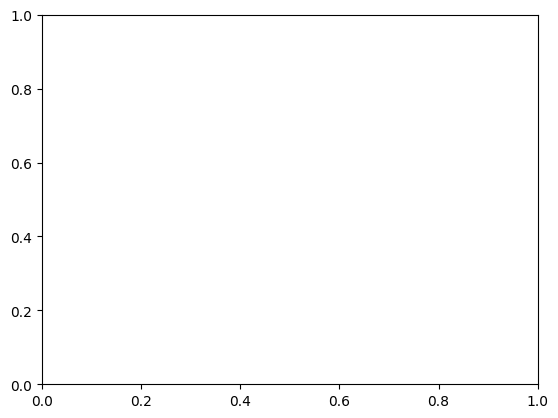

In [21]:
for idx in range(10):
    mushroom.train_dl.dataset.display_batch(
        batch, idx, mushroom.learner_data.dtype_to_channels,
        display_channels={'xenium': 'EPCAM', 'multiplex': 'E-Cadherin', 'visium': 'EPCAM', 'he': 'green'}
    )
    plt.show()

In [20]:
device = mushroom.model.device
with torch.no_grad():
    tiles, slides, dtypes = batch['tiles'], batch['slides'], batch['dtypes']
    pairs, is_anchor = batch['pairs'], batch['is_anchor']
    
    tiles, slides, dtypes = [x.to(device) for x in tiles], [x.to(device) for x in slides], [x.to(device) for x in dtypes]
    pairs, is_anchor = [x.to(device) for x in pairs], [x.to(device) for x in is_anchor]
    losses, outputs = mushroom.model.sae(tiles, slides, dtypes, pairs=pairs, is_anchor=is_anchor)

In [21]:
losses

{'neigh_loss_level_0': tensor(1.9780),
 'recon_loss_0_xenium': tensor(1.4632),
 'neigh_loss_level_1': tensor(1.2638),
 'recon_loss_1_xenium': tensor(1.4631),
 'neigh_loss_level_2': tensor(0.5838),
 'recon_loss_2_xenium': tensor(1.4631),
 'recon_loss': tensor(4.3895),
 'neigh_loss': tensor(3.8256),
 'overall_loss': tensor(4.3895)}

In [22]:
outputs.keys()

dict_keys(['encoded_tokens_prequant', 'level_to_encoded', 'cluster_probs', 'clusters', 'dtype_to_true_pixels', 'dtype_to_pred_pixels'])

In [23]:
for level in outputs['cluster_probs']: print(level.shape)

torch.Size([256, 64, 8])
torch.Size([256, 64, 4])
torch.Size([256, 64, 2])


In [24]:
for level in outputs['clusters']: print(level.shape)

torch.Size([256, 64])
torch.Size([256, 64])
torch.Size([256, 64])


In [25]:
for level in outputs['clusters']: print(level.unique())

tensor([0, 1, 2, 3, 4, 5, 6, 7])
tensor([0, 1, 2, 3])
tensor([0, 1])


In [26]:
for level in outputs['level_to_encoded']: print(len(level.sum(-1).unique()))

8
32
64


In [27]:
for k, v in outputs['dtype_to_true_pixels'].items():
    print(k, v.shape)

xenium torch.Size([256, 64, 477])


In [28]:
for k, v in outputs['dtype_to_pred_pixels'].items():
    print(k, v.shape)

xenium torch.Size([3, 256, 64, 477])


In [29]:
sum([v.shape[1] for k, v in outputs['dtype_to_true_pixels'].items()])

64

In [30]:
# ~11 iter per second

In [15]:
mushroom.train()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/htan_talk/mushroom/xenium_HT413C1_Th1k4A1_v1/outputs/chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.2 M 
------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.992    Total estimated model params size (MB)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
# mushroom.embed_sections()

In [ ]:
# outputs = []
# pl_module = mushroom.model
# with torch.no_grad():
#     for batch in mushroom.inference_dl:
#         tiles, slides, dtypes = batch['tiles'], batch['slides'], batch['dtypes']
#         tiles = [x.to(pl_module.device) for x in tiles]
#         slides = [x.to(pl_module.device) for x in slides]
#         dtypes = [x.to(pl_module.device) for x in dtypes]
#         outs = pl_module.forward(tiles, slides, dtypes)
#         outputs.append(outs)

In [ ]:
# out = mushroom.model.format_prediction_outputs(outputs)

In [16]:
os.path.join(mushroom_config['trainer_kwargs']['save_dir'], 'mushroom_config.yaml')

'/data/estorrs/mushroom/data/projects/htan_talk/mushroom/xenium_HT413C1_Th1k4A1_v1/outputs/chkpts/mushroom_config.yaml'

In [13]:
new = Mushroom.from_config(
    os.path.join(mushroom_config['trainer_kwargs']['save_dir'], 'mushroom_config.yaml'),
    chkpt_filepath=f'/data/estorrs/mushroom/data/projects/htan_talk/mushroom/xenium_HT413C1_Th1k4A1_v1/outputs/chkpts/last-v1.ckpt',
    accelerator='cpu'
)


INFO:root:starting xenium processing
INFO:root:using 477 channels
INFO:root:5 sections detected: ['s2', 's5', 's9', 's13', 's21']
INFO:root:processing sections
INFO:root:generating image data for section s2
INFO:root:generating image data for section s5
INFO:root:generating image data for section s9
INFO:root:generating image data for section s13
INFO:root:generating image data for section s21
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 5 sections detected: [('s2', 'xenium'), ('s5', 'xenium'), ('s9', 'xenium'), ('s13', 'xenium'), ('s21', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/htan_talk/mushroom/xenium_HT413C1_Th1k4A1_v1/outputs/chkpts/last-v1.ckpt


In [14]:
new.embed_sections()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

In [15]:
dtype_to_df = new.get_cluster_intensities()
dtype_to_df[dtype]

,ABCC11,ACAN,ACE2,ACKR1,ACTA2,ACTG2,ADAM28,ADAMTS1,ADGRE1,ADGRL4,...,UCHL1,UMOD,UPK3B,VCAN,VEGFA,VIM,VPREB1,VSIG4,VWA5A,VWF
0,0.252300,0.416230,0.830584,0.708429,0.527182,1.689530,0.813401,0.299695,0.885313,1.027378,...,0.700343,0.703594,0.546222,0.491592,1.797762,0.909243,0.787658,0.459458,1.255481,0.509776
1,0.314052,0.490837,1.096557,0.883752,0.477621,2.157043,0.852276,0.241953,1.084976,1.136116,...,0.737181,0.870878,0.696330,0.364248,2.328490,0.889184,0.945285,0.496368,1.617727,0.536957
2,0.139654,0.179723,0.466157,0.588046,0.423894,1.062641,0.715139,0.342550,0.681899,0.744297,...,0.639443,0.478615,0.395112,0.518991,1.112442,0.830055,0.544710,0.316311,0.710158,0.374629
3,0.084261,0.715097,0.173481,0.260325,1.371488,0.661122,1.250402,1.385679,0.432090,1.168354,...,0.834404,0.228480,0.119427,1.523750,0.371105,1.773785,0.294853,1.020134,0.604469,0.982805
4,0.159055,0.783613,0.382017,0.469652,1.422446,0.978560,1.398535,1.458511,0.651810,1.298368,...,0.912290,0.385742,0.236850,1.550107,0.699548,1.874051,0.440763,1.178940,0.813392,1.075839
5,0.079886,0.558256,0.188406,0.267232,1.149139,0.636816,1.079212,1.101826,0.419994,1.012353,...,0.785579,0.239533,0.142774,1.336200,0.419985,1.533905,0.284815,0.834136,0.553749,0.785082
6,0.046615,0.335954,0.030515,0.162404,1.073079,0.234356,0.939945,1.016396,0.264737,0.603590,...,0.744768,0.105366,0.017125,1.368498,-0.031611,1.373465,0.152254,0.829775,0.182728,0.611647
7,0.077250,1.125661,0.131054,0.250610,1.967705,0.810675,1.697281,1.999418,0.452975,1.711876,...,1.005734,0.205804,0.104063,2.069029,0.363183,2.428896,0.318293,1.363250,0.820404,1.373805
8,0.153945,1.004213,0.208776,0.452644,2.132400,0.542127,2.076267,2.549237,0.659396,1.294659,...,1.229301,0.240313,0.067463,2.556540,-0.105692,2.756049,0.245650,2.086984,0.488966,1.600037
9,0.305118,0.345426,0.175569,0.271944,0.829553,0.261151,0.801022,1.271124,0.295193,0.636327,...,0.449320,0.089656,0.015337,0.874892,-0.044256,1.131654,0.137885,1.165788,0.245593,0.862110


In [16]:
dtype_to_df[dtype].to_csv(f'/data/estorrs/sandbox/{case}_{dtype}_l2_neighborhoods.txt', sep='\t')

array([[<Axes: title={'center': 's2'}, ylabel='predicted'>,
        <Axes: title={'center': 's5'}>, <Axes: title={'center': 's9'}>,
        <Axes: title={'center': 's13'}>, <Axes: title={'center': 's21'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

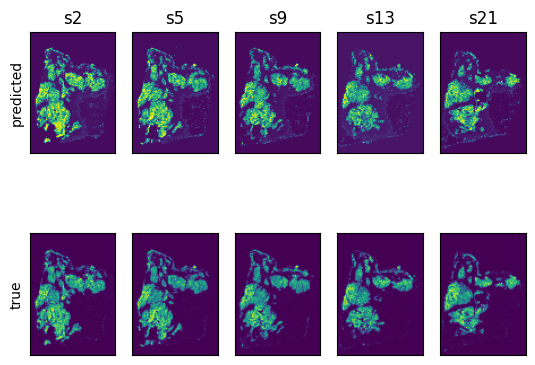

In [22]:
new.display_predicted_pixels('EPCAM', dtype, level=-1)

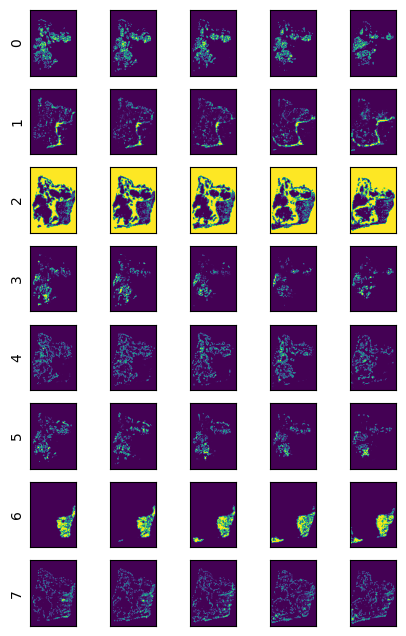

In [23]:
new.display_cluster_probs(level=0)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

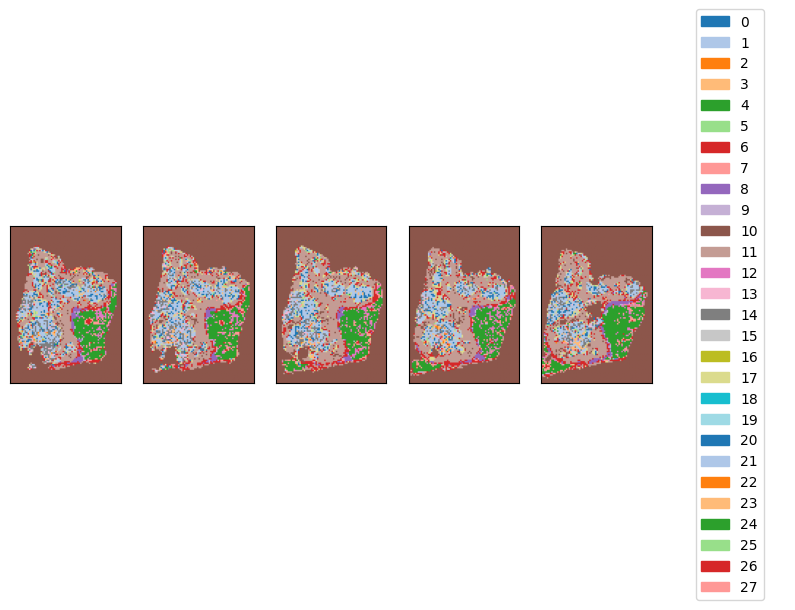

In [24]:
new.display_clusters()
plt.savefig(f'/data/estorrs/sandbox/{case}_{dtype}_l2_neighborhoods.pdf', dpi=300)

In [28]:
volume = new.generate_interpolated_volume(z_scaler=.1)
volume.shape

(19, 108, 76)

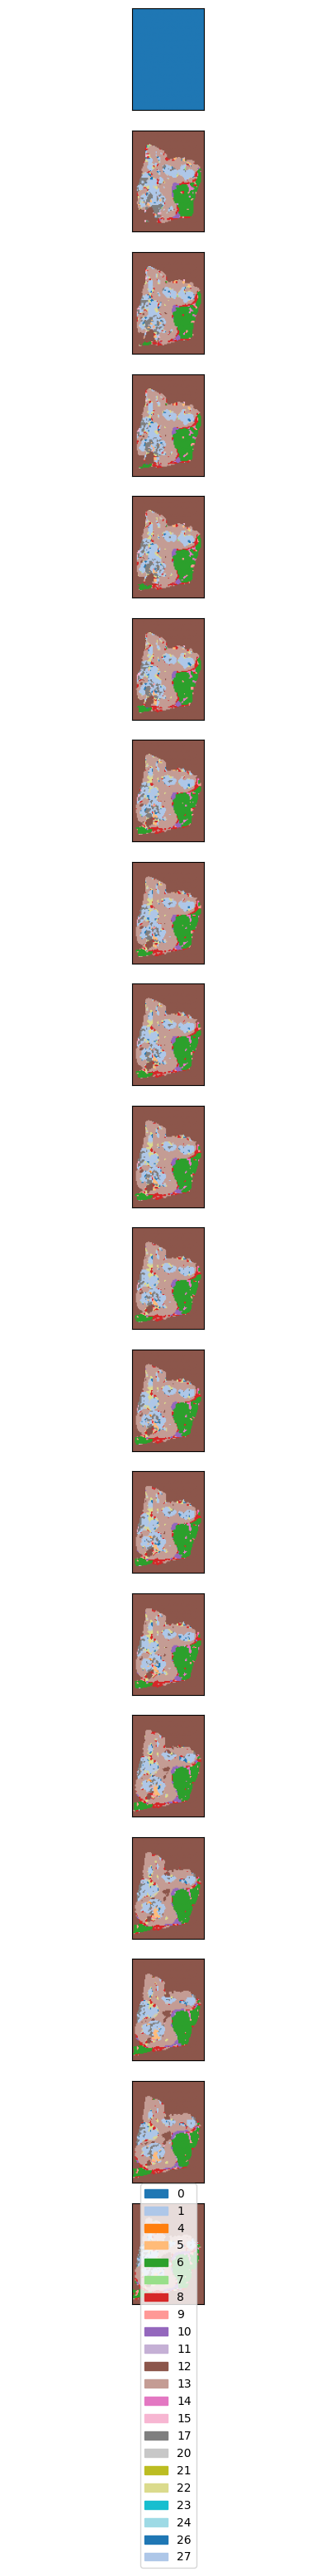

In [29]:
vis_utils.display_clusters(volume, horizontal=False, preserve_indices=True)

In [30]:
new.clusters[-1].shape

(5, 108, 76)

In [31]:
new.cluster_probs[-1].shape

(5, 108, 76, 2)

In [32]:
out_fp = os.path.join(mushroom_config['trainer_kwargs']['save_dir'], 'outputs.npy')
np.save(out_fp, {
    'cluster_ids': new.clusters,
    'cluster_probs': new.cluster_probs,
    'cluster_volume': volume,
})


In [45]:
os.path.join(mushroom_config['trainer_kwargs']['save_dir'], 'outputs.npy')

'/data/estorrs/mushroom/data/projects/htan_talk/mushroom/xenium_HT413C1_Th1k4A1_v1/outputs/chkpts/outputs.npy'

In [19]:
import mushroom.data.datasets as datasets
import mushroom.data.visium as visium
import mushroom.data.multiplex as multiplex
import mushroom.data.xenium as xenium

In [20]:
sid_to_filepaths, section_ids, fps = datasets.get_config_info(config, dtype)
# sid_to_adata = {sid:visium.adata_from_visium(fp) for sid, fp in sid_to_filepaths.items()}

In [35]:
# new.dtype_to_channels[dtype]

In [39]:
new.true_pixels[0].shape

(108, 76, 477)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 10 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'nine', 'nonmarkingreturn', 'one', 's', 'space', 'three', 'two']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 20, 21, 22, 24, 28, 86]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 10 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'nine', 'nonmarkingreturn', 'one', 's', 'space', 'three', 'two']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 20, 21, 22, 24, 28, 86]
INFO:fontTools.subset:Closing glyph list over 'MATH': 10 glyphs before
INFO:fontTools

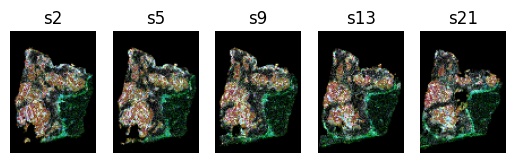

In [46]:
cmap = {
    'EPCAM': (1., 0., 0.),
    'PTPRC': (0., 1., 0.),
    'ACTA2': (1., 1., 1.),
    'HLA-DQB2': (0., 0., 1.),
}

contrast_mapping = {
    'EPCAM': 90.,
    'PTPRC': 95.,
    'ACTA2': 95.,
    'HLA-DQB2': 95.,
#     'CD31': 99.,
}

fig, axs = plt.subplots(ncols=len(new.true_pixels))
for sid, img, ax in zip(section_ids, new.true_pixels, axs):
    channel_to_img = {c:img[..., i] for i, c in enumerate(new.dtype_to_channels[dtype])
                     if c in cmap}
    rgb = multiplex.make_pseudo(
        channel_to_img, cmap=cmap, contrast_mapping=contrast_mapping)
    ax.imshow(rgb)
    ax.axis('off')
    ax.set_title(sid)
plt.savefig('/data/estorrs/sandbox/HT413C1_Th1k4A1_xenium_sections.pdf', dpi=300)

In [44]:
for sid, fp in zip(new.section_ids, fps):
    print(sid)
    adata = visium.adata_from_visium(fp)
    labels = new.assign_pts(adata.obsm['spatial'], section_id=sid)
    adata.obs['neighborhood'] = [f'nbhd {x}' for x in labels]
    df = adata.obs[['neighborhood']]
    
    slide = sid[0]
    df.to_csv(f'/data/estorrs/sandbox/{case}_{dtype}_{slide}_l2_neighborhoods.txt', sep='\t')

('s2', 'xenium')
('s5', 'xenium')
('s9', 'xenium')
('s13', 'xenium')
('s21', 'xenium')
